## This is to calculate the wake and fit for all cases
### First is to look at the no structure Elegant output
### Then, load in the specific case we want to look at
### Finally, compare the two

# Load dependencies

In [1]:
import sys 
import subprocess
from matplotlib import rc
import os 
sys.path.insert(0, '/lstr/sahara/aard/cphillips/ipynbfiles/conversion')
import numpy as np
import matplotlib.pyplot as plt
import eleganttool2
#from eleganttool import import_numericaldata
from IPython.display import display, Markdown
import scipy.constants as sc
import scipy.optimize as scfit

# install directories for PELEGANT and SDDS tools (should not be needed)
sddspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/epics/extensions/bin/linux-x86_64/'
appspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/oag/apps/bin/linux-x86_64/'

FontSize=16
          
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', size = FontSize)

PWD=subprocess.run('pwd',stdout=subprocess.PIPE)
PWD.stdout


frac = 100

def fitfunc(x, a, b, c, d):
    return a* np.sin(b*x+c)+d

def circfunc(x, a, b, c, d, e):
    return a*np.sin(b*x+c)+d*x + e

# No Structure and Specific Case Locations

In [2]:
base = '/lstr/sahara/aard/cphillips/bebop_opal_Eleg/'
nostruct = '2Eley42structure/nostructure/'
wistruct = '4LPS/slit/diffstages/rect/end/'
#wistruct = '4LPS/slit/diffstages/square/end/'
#wistruct = '4LPS/slit/diffstages/circle/end/'


wakeplotname = '10slit10cmrect.png'

circle = 0

sddsno = 'c2y4.sdds'
sddswi = '10cm10.sdds'

out = 'optscript.out'


#inputno = base+nostruct+sddsno
#inputwi = base+wistruct+sddswi
outputno = base+nostruct+out
outputwi = base+wistruct+out


# Get and Plot Both Cases

Number of particles at end without structure:  30000 30000


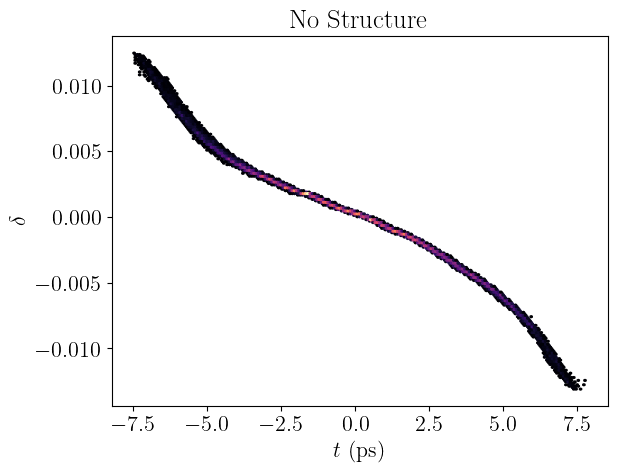

Number of particles at end with structure:  2027 2027


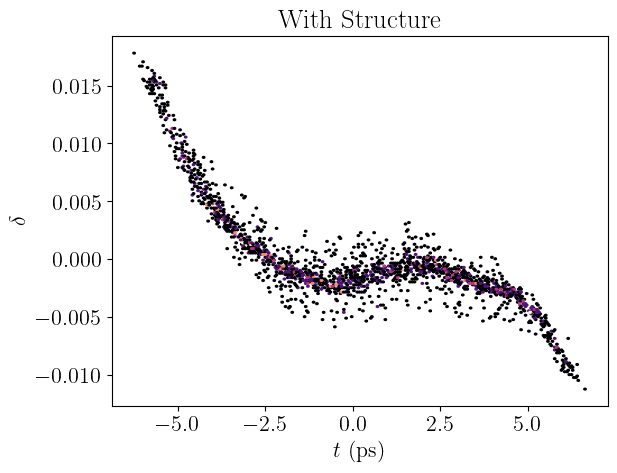

In [3]:
# ----------------------------------------------------------
# Start with no structure
# ----------------------------------------------------------
nots = eleganttool2.import_numericaldata(outputno,column='t')
nots = (nots - nots.mean())*1e12 # Get picosec
nop = eleganttool2.import_numericaldata(outputno,column='p')
nodel = nop/nop.mean()-1 # get delta instead of absolute momentum

print('Number of particles at end without structure: ',len(nots),len(nodel))

MinCnt = 1+int(len(nots)-frac/100*len(nots))
plt.hexbin(nots,nodel,gridsize = 201, mincnt=MinCnt,cmap='magma')
plt.xlabel('$t$ (ps)')
plt.ylabel(r'$\delta$')
plt.title('No Structure')
plt.show()

# ----------------------------------------------------------
# Now, include case with structure; have to do various calculations to get in terms of t and delta
# ----------------------------------------------------------
wix = eleganttool2.import_numericaldata(outputwi,column='x')
wixp = eleganttool2.import_numericaldata(outputwi,column='xp')
wiy = eleganttool2.import_numericaldata(outputwi,column='y')
wiyp = eleganttool2.import_numericaldata(outputwi,column='yp')
R16 = float(eleganttool2.import_strdata(base+wistruct+'optscript.fin',column='R16')[0])
pcent = eleganttool2.import_strdata(outputwi,column='pCentral')

# Conversion of final yag's xy to t-delta; keep everything in m...
# Let's convert x to delta first, for the Spectrometer
# using the 6d matrix element for x = R16*delta, we can get the first order approx for delta
multd = 1.0/R16
widel = wix*multd

# Now, let's convert y to t, for the TDC
# from using the matrix of drift_tdc_spec + spec + drift_spec_yag, we grab R12 = (sin(th)*r^2+b(cos(th)*r-sin(th)*a)+cos(th)ar)/r
# where r is the radius of curvature, a is the distance tdc to spec, b is distance spec to yag, and th is the bending angle
# https://cds.cern.ch/record/1415916/files/p395.pdf equation 10
bending_angle = 20*np.pi/180
rc = 0.301752/bending_angle # radius of curvature is length of dipole divided by bending angle
kappa = 3.0135
len_tdc = 0.7477760000000011
len_dip_yag = 0.738124
len_tdc_dip = 0.4808219999999967

div = kappa*(len_tdc_dip + len_dip_yag + bending_angle*rc) + len_tdc*kappa/2
multz = 1/div
wiz = -multz*wiy # convert y to z
wits = wiz/sc.c # convert the z to t
wits = wits*1e12 # convert sec to ps

print('Number of particles at end with structure: ',len(wix),len(wiy))


plt.hexbin(wits,widel,gridsize = 201, mincnt=MinCnt,cmap='magma')
plt.xlabel('$t$ (ps)')
plt.ylabel(r'$\delta$')
plt.title('With Structure')
plt.show()

# Create 2D histogram and find average location then subtract to get wake

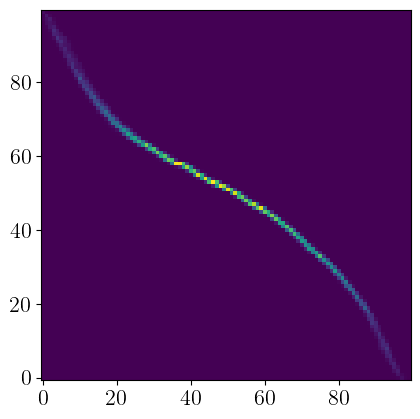

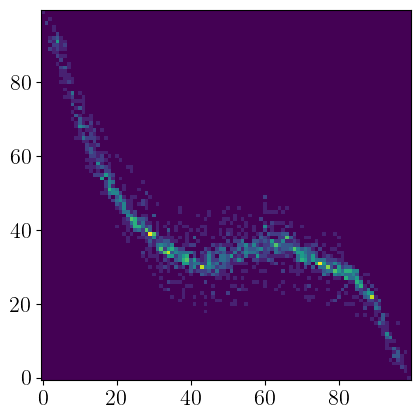

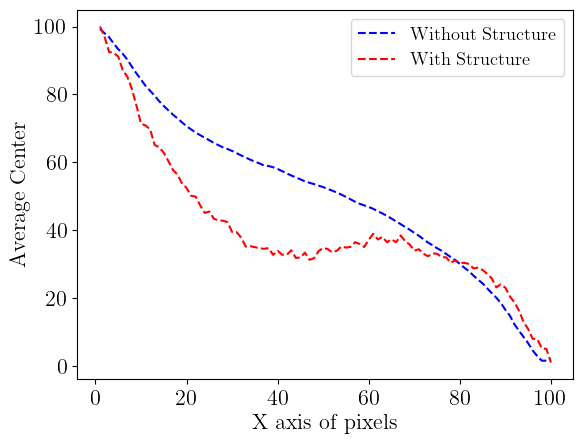

[-14.44490843   0.05968013  -0.59107655  -9.74665605]


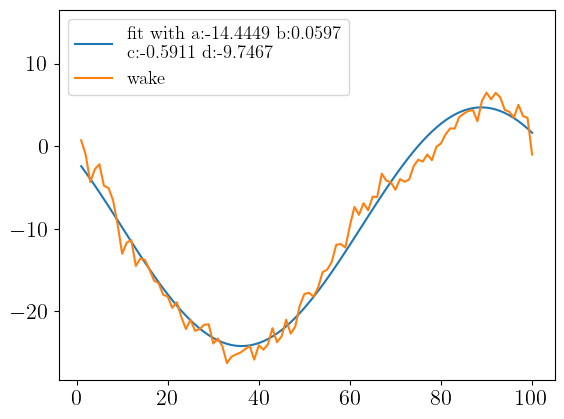

/lstr/sahara/aard/cphillips/bebop_opal_Eleg/4LPS/slit/diffstages/rect/end/10slit10cmrect.png


In [4]:
xbins = 100
ybins = 100


nomatrix, noxed, noyed = np.histogram2d(nodel,nots, bins = (xbins,ybins))#, range = [[minx,maxx],[miny,maxy]]) 
wimatrix, wixed, wiyed = np.histogram2d(widel,wits, bins = (xbins,ybins))#, range = [[minx,maxx],[miny,maxy]]) 


# imshow of no structure
plt.imshow(nomatrix)
plt.gca().invert_yaxis()
plt.show()

# imshow of with structure
plt.imshow(wimatrix)
plt.gca().invert_yaxis()
plt.show()

# Getting the average of both; no structure first then with structure
xs = np.arange(1,xbins+1)
ys = np.arange(1,ybins+1)

xy, jk = np.meshgrid(xs, ys, indexing='xy')

nonumer = np.sum(nomatrix*jk, axis=0)
nodenom = np.sum(nomatrix,axis=0)
for i, x in enumerate(nodenom):
    if x == 0: nodenom[i] = 1e-12
noavglocs = nonumer/nodenom

winumer = np.sum(wimatrix*jk, axis=0)
widenom = np.sum(wimatrix,axis=0)
for i, x in enumerate(widenom):
    if x == 0: widenom[i] = 1e-12
wiavglocs = winumer/widenom

plt.plot(xs, noavglocs,'b--',label='Without Structure')
plt.plot(xs, wiavglocs,'r--',label='With Structure')
plt.legend(fontsize='small')
plt.xlabel('X axis of pixels')
plt.ylabel('Average Center')
plt.show()

wake = wiavglocs - noavglocs

#----------------------------------
# estimating for circle
#----------------------------------
#estimate a
est_a = (noxed[-1]-noxed[0])/2
#estimate b
num_wl = 2.5
actual_width = noyed[-1] - noyed[0]
b_est = num_wl/actual_width

if circle == 1:
    params, params_covariance = scfit.curve_fit(circfunc,xs,wake,p0=[15,b_est,2.2,2,-5.3],maxfev=500000)
    fitwake = circfunc(xs, params[0], params[1],params[2],params[3],params[4])
    plt.plot(xs, fitwake,label='fit with a:'+str(round(params[0],4))+' b:'+str(round(params[1],4))+'\n'+' c:'+str(round(params[2],4))+' d:'+str(round(params[3],4))+' e:'+str(round(params[4],4)))
else: 
    params, params_covariance = scfit.curve_fit(fitfunc,xs,wake,p0=[30,0.04,np.pi/10,2],maxfev=5000)
    fitwake = fitfunc(xs, params[0], params[1],params[2],params[3])
    plt.plot(xs, fitwake,label='fit with a:'+str(round(params[0],4))+' b:'+str(round(params[1],4))+'\n'+' c:'+str(round(params[2],4))+' d:'+str(round(params[3],4)))

print(params)


plt.plot(xs, wake,label='wake')
plt.legend(fontsize='small')
#plt.xlabel('t (ps)')
#plt.ylabel(r'$\Delta\delta$')
plt.ylim([np.min(wake)-2,np.max(wake)+10])
plt.savefig(base+wistruct+wakeplotname)
plt.show()
print(base+wistruct+wakeplotname)


# This is trying to convert to the correct t and delta, but impossible, because the two plots are offset

7.754146035312755 -7.472017875438791 0.017797545780432834 -0.013096098137245882
[-0.0130961  -0.01278716 -0.01247823 -0.01216929 -0.01186035 -0.01155142
 -0.01124248 -0.01093354 -0.01062461 -0.01031567 -0.01000673 -0.0096978
 -0.00938886 -0.00907992 -0.00877099 -0.00846205 -0.00815312 -0.00784418
 -0.00753524 -0.00722631 -0.00691737 -0.00660843 -0.0062995  -0.00599056
 -0.00568162 -0.00537269 -0.00506375 -0.00475481 -0.00444588 -0.00413694
 -0.003828   -0.00351907 -0.00321013 -0.0029012  -0.00259226 -0.00228332
 -0.00197439 -0.00166545 -0.00135651 -0.00104758 -0.00073864 -0.0004297
 -0.00012077  0.00018817  0.00049711  0.00080604  0.00111498  0.00142391
  0.00173285  0.00204179  0.00235072  0.00265966  0.0029686   0.00327753
  0.00358647  0.00389541  0.00420434  0.00451328  0.00482222  0.00513115
  0.00544009  0.00574902  0.00605796  0.0063669   0.00667583  0.00698477
  0.00729371  0.00760264  0.00791158  0.00822052  0.00852945  0.00883839
  0.00914733  0.00945626  0.0097652   0.010074

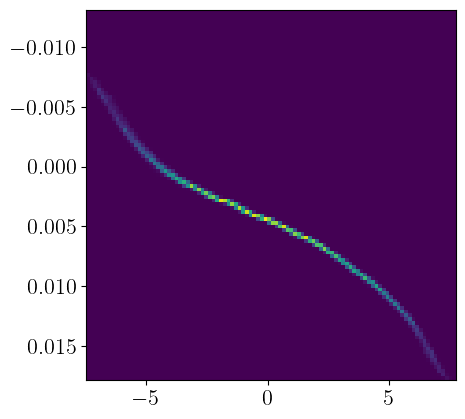

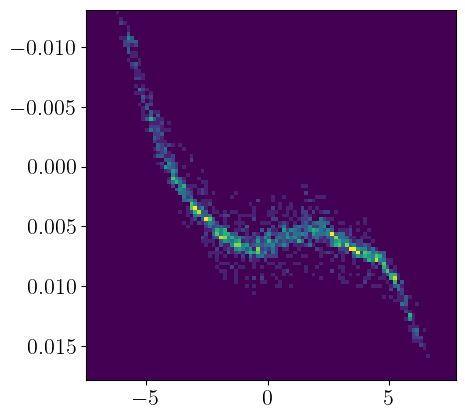

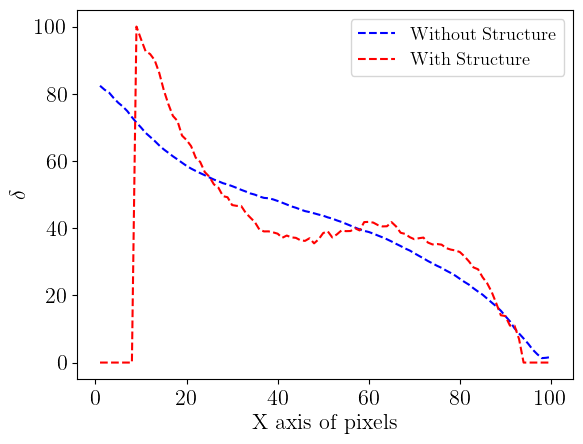

[14.38939074  0.12311601 -1.47679255 -4.95880032]
4 5


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

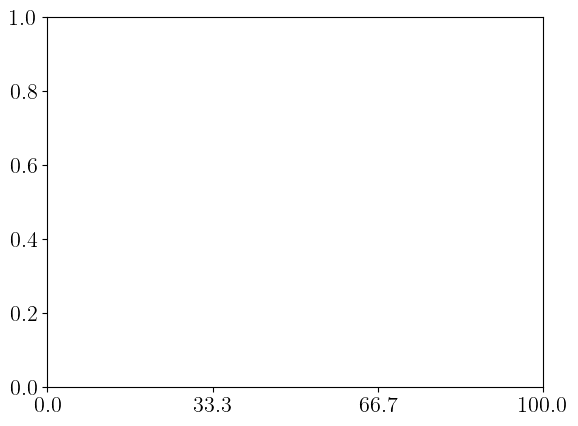

In [5]:
xbins = 100
ybins = 100
ratio = 1.0

allts = np.append(nots,wits)
alldel = np.append(nodel,widel)

maxx = np.max(allts)
minx = np.min(allts)
maxy = np.max(alldel)
miny = np.min(alldel)

print(maxx,minx,maxy,miny)

nomatrix, noxed, noyed = np.histogram2d(nodel,nots, range = [[miny,maxy],[minx,maxx]], bins = (xbins,ybins))#, range = [[minx,maxx],[miny,maxy]]) 
wimatrix, wixed, wiyed = np.histogram2d(widel,wits, range = [[miny,maxy],[minx,maxx]], bins = (xbins,ybins))#, range = [[minx,maxx],[miny,maxy]]) 
print(noxed,noyed)

# imshow of no structure
plt.imshow(nomatrix, extent=[noyed[0],noyed[-1],noxed[0],noxed[-1]])
plt.gca().invert_yaxis()
plt.gca().set_aspect(abs((noyed[-1]-noyed[0])/(noxed[-1]-noxed[0]))*ratio)
plt.show()

# imshow of with structure
plt.imshow(wimatrix, extent=[noyed[0],noyed[-1],noxed[0],noxed[-1]])
plt.gca().invert_yaxis()
plt.gca().set_aspect(abs((noyed[-1]-noyed[0])/(noxed[-1]-noxed[0]))*ratio)
plt.show()

# Getting the average of both; no structure first then with structure
xs = np.arange(1,xbins+1)
ys = np.arange(1,ybins+1)

xy, jk = np.meshgrid(xs, ys, indexing='xy')

nonumer = np.sum(nomatrix*jk, axis=0)
nodenom = np.sum(nomatrix,axis=0)
for i, x in enumerate(nodenom):
    if x == 0: nodenom[i] = 1e-12
noavglocs = nonumer/nodenom

winumer = np.sum(wimatrix*jk, axis=0)
widenom = np.sum(wimatrix,axis=0)
for i, x in enumerate(widenom):
    if x == 0: widenom[i] = 1e-12
wiavglocs = winumer/widenom

plt.plot(xs, noavglocs,'b--',label='Without Structure')
plt.plot(xs, wiavglocs,'r--',label='With Structure')
plt.legend(fontsize='small')
plt.xlabel('X axis of pixels')
plt.ylabel(r'$\delta$')
plt.show()

wake = wiavglocs - noavglocs
params, params_covariance = scfit.curve_fit(fitfunc,xs,wake,p0=[20,0.05,np.pi/10,2])
print(params)

fitwake = fitfunc(xs, params[0], params[1],params[2],params[3])

binnums = np.arange(0,xbins+1,xbins/3)

lenx = maxx-minx
xticklist = np.arange(minx,maxx+lenx/2,lenx/3)
print(len(binnums),len(xticklist))

plt.xticks(binnums,xticklist)
leny = maxy-miny
yticklist = np.arange(miny,maxy+leny/2,leny/3)
plt.yticks(yticklist)


plt.plot(xs, wake)
plt.plot(xs, fitwake)
plt.xlabel('t')
plt.ylabel(r'$\Delta\delta$')
plt.show()

